In [1]:
import os
from shutil import copyfile, rmtree

import fastai
from fastai.vision import *
from fastai.callbacks import *
from fastai.utils.mem import *

from torchvision.models import vgg16_bn

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.pyplot import imshow


import warnings; warnings.simplefilter('ignore')

import PIL
from PIL import ImageDraw

%matplotlib inline

In [2]:
data_dir = "games_collected"

In [3]:
df = pd.read_csv(f'{data_dir}/team/full_coordinates.csv')
df = df.sort_values(by=['image_name'])
df = df[df.image_name != "test_0000000000"]
df = df[df.image_name != "test_0000000001"]
df = df[df.image_name != "test_0000000002"]
df = df[df.image_name != "test_0000000003"]
df = df[df.image_name != "test_0000000004"]
df

,image_name,tags
22498,cg_mmm_worlds_2019_0000000000,10-10 10-6 10-7 11-7 2-2 3-3 5-5 7-6 7-7 7-9
31831,cg_mmm_worlds_2019_0000000001,10-11 10-7 11-11 11-7 11-8 13-10 2-2 3-3 3-4 5...
8573,cg_mmm_worlds_2019_0000000002,1-2 10-10 10-11 10-6 10-7 11-7 2-2 2-3 3-3 5-1...
10141,cg_mmm_worlds_2019_0000000003,1-2 10-11 10-6 10-7 10-8 11-7 2-2 2-3 3-3 5-12...
27090,cg_mmm_worlds_2019_0000000004,10-11 10-7 11-7 11-8 2-2 3-3 6-11 6-12 6-6 7-1...
...,...,...
10943,spy_uol_6_2019_0000001595,10-4 10-5 10-6 11-4 11-5 11-6 12-4 12-5 12-6 1...
6781,spy_uol_6_2019_0000001596,10-4 10-5 11-4 11-5 12-4 12-5 5-5 9-4 9-5
6136,spy_uol_6_2019_0000001597,10-3 10-4 10-5 12-4 12-5 13-5 9-5
32478,spy_uol_6_2019_0000001598,10-4 10-5 11-4 12-4 12-5 9-4 9-5


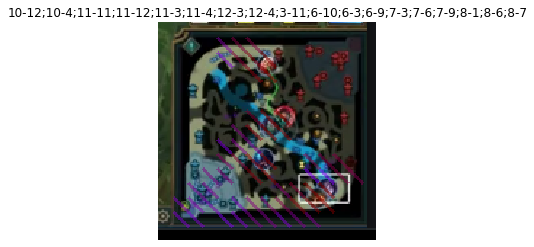

In [4]:
data = (ImageList.from_df(df, data_dir+"/composite", suffix='.png')
        .split_by_idx(range(0,int(len(df)/5)))
        .label_from_df(label_delim=' ')
        .databunch(bs=64)
        .normalize(imagenet_stats))

data.show_batch(rows=1)

https://gilberttanner.com/blog/fastai-multi-label-image-classification

In [10]:
thresh = 0.2
acc_02 = partial(accuracy_thresh, thresh=thresh)
f_score = partial(fbeta, thresh=thresh)
learn = create_cnn(data, models.resnet50, metrics=[acc_02, f_score])
learn.callbacks = [SaveModelCallback(learn, every='improvement', mode='min', name='best')]
gc.collect()

0

In [6]:
# learn.lr_find()
# learn.recorder.plot()

In [12]:
lr = 0.02
learn.fit_one_cycle(1, lr)

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.165580,0.175435,0.909120,0.530937,01:56


Better model found at epoch 0 with valid_loss value: 0.1754351407289505.


In [13]:
learn.unfreeze()

In [14]:
learn.fit_one_cycle(6, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.162636,0.174681,0.907994,0.536111,02:34
1,0.155605,0.174474,0.913648,0.528405,02:35
2,0.147721,0.168872,0.914272,0.560443,02:36
3,0.136637,0.168314,0.914594,0.564412,02:36
4,0.125125,0.169966,0.909471,0.574534,02:35
5,0.116109,0.172342,0.913187,0.569000,02:36


Better model found at epoch 0 with valid_loss value: 0.17468073964118958.
Better model found at epoch 1 with valid_loss value: 0.1744740903377533.
Better model found at epoch 2 with valid_loss value: 0.16887179017066956.
Better model found at epoch 3 with valid_loss value: 0.16831383109092712.


### Results
* learn.fit_one_cycle(10, slice(1e-5, lr/5)) == lr=0.05 Resnet50 == No Composite
* Better model found at epoch 7 with valid_loss value: 0.16599667072296143.
* learn.fit_one_cycle(10, slice(1e-5, lr/5)) == lr=0.05 Resnet50 == Stripe composite
* Better model found at epoch 4 with valid_loss value: 0.16605345904827118.

In [15]:
preds = learn.get_preds(ds_type=DatasetType.Valid)

In [16]:
grid_size = 10
def draw_grid(draw, labels):
    fill = (0, 255, 255, 96)
    for l in labels:
        x = l[0] * grid_size
        y = l[1] * grid_size
        draw.rectangle((x, y, x + grid_size, y + grid_size), fill=fill)
        
def process(image):
    plt.figure()
    plt.imshow(image)
        
def draw_preds(index):
    p = preds[0][index]
    classes = [data.classes[i] for i in range(len(p)) if p[i] > thresh]
    classes = [(int(c.split("-")[0]), int(c.split("-")[1])) for c in classes]

    filename = learn.data.valid_ds.items[index]
    img = PIL.Image.open(filename)

    overlay = PIL.Image.new('RGBA', img.size, (255, 255, 255, 0))
    draw = ImageDraw.Draw(overlay)
    draw_grid(draw, classes)
    out = PIL.Image.alpha_composite(img, overlay)

    process(out)
    filename =  filename.split("/")[-1]
    filename = data_dir+"/full/"+filename
    img = PIL.Image.open(filename)
    process(img)

In [34]:
k = 1200

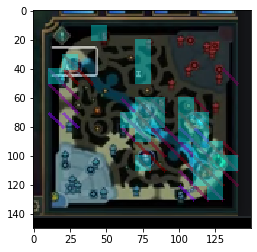

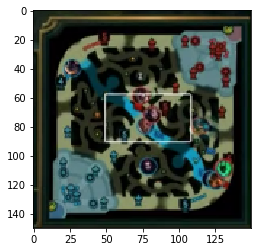

In [46]:
k += random.randint(10, 50)
draw_preds(k)

In [47]:
learn.export("models/predict.pth")